In [1]:
import zipfile
import os
import pandas as pd
import plotly.express as px

In [2]:
def concatenar_csvs(diretorio):
    frames = []

    for arquivo in os.listdir(diretorio):
        if arquivo.endswith('.csv'):
            caminho_arquivo = os.path.join(diretorio, arquivo)
            
            df = pd.read_csv(caminho_arquivo, encoding='utf-8', delimiter=";", decimal=",")
            df = df.rename(columns={df.columns[0]: "data_base"})
            df['data_base'] = pd.to_datetime(df['data_base'], format="%Y-%m-%d")
            df['mes'] = df['data_base'].dt.month #cria uma nova coluna com mês

              #Filtros:
            df = df[df['mes'] == 12] #trocar para o ano que você quer filtrar
            df['porte'] = df['porte'].str.replace(' ','')
            filtro1 = df['porte'] == "PJ-Micro"
            filtro2 = df['porte'] == "PJ-Pequeno"
            df = df.loc[filtro1 | filtro2]
            df['porte']=df['porte'].str.replace('PJ-','')
            df['modalidade']=df['modalidade'].str.replace('PJ - ','')
            df = df[['data_base', 'modalidade', 'porte', 'a_vencer_ate_90_dias','a_vencer_de_91_ate_360_dias']]
            
            #Nova coluna para endividamento de curto prazo
            df['curto_prazo'] = df['a_vencer_ate_90_dias'] + df['a_vencer_de_91_ate_360_dias']
            df = df.drop(columns = ['a_vencer_ate_90_dias', 'a_vencer_de_91_ate_360_dias'], axis = 1)
            df['data_base'] = df['data_base'].dt.strftime('%Y-%m')
            
            #Agrupamentos para análise
            df = df.groupby(['data_base','modalidade','porte'])['curto_prazo'].sum().reset_index()
            
            frames.append(df)

    df_concatenado = pd.concat(frames, ignore_index=True)

    return df_concatenado

In [3]:
anos = list(range(2012, 2024))
dataframes = []

for ano in anos:
    diretorio = f"planilha_{ano}"
    dataframe_ano = concatenar_csvs(diretorio)
    dataframes.append(dataframe_ano)

df_total = pd.concat(dataframes, ignore_index=False)

In [4]:
df_total.head()

,data_base,modalidade,porte,curto_prazo
0,2012-12,Capital de giro,Micro,2.254850e+10
1,2012-12,Capital de giro,Pequeno,3.326240e+10
2,2012-12,Cheque especial e conta garantida,Micro,5.704846e+09
3,2012-12,Cheque especial e conta garantida,Pequeno,9.197790e+09
4,2012-12,Comércio exterior,Micro,4.958361e+09


In [5]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 198 entries, 0 to 17
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   data_base    198 non-null    object 
 1   modalidade   198 non-null    object 
 2   porte        198 non-null    object 
 3   curto_prazo  198 non-null    float64
dtypes: float64(1), object(3)
memory usage: 7.7+ KB


In [6]:
import deflatebr as dbr

In [7]:
df_total['curto_prazo_deflacionado'] = dbr.deflate(nominal_values=df_total['curto_prazo'], nominal_dates=df_total['data_base'], real_date='2022-12') 

C:\Users\ticia\anaconda3\lib\site-packages\deflatebr\deflate.py:90: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df['deflated'] = df[['nom_values', 'VALVALOR']].apply(lambda x: ((real_indx/x[1]) * x[0])[0], axis=1)


In [8]:
df_total.head(3)

,data_base,modalidade,porte,curto_prazo,curto_prazo_deflacionado
0,2012-12,Capital de giro,Micro,2.254850e+10,4.084276e+10
1,2012-12,Capital de giro,Pequeno,3.326240e+10,6.024916e+10
2,2012-12,Cheque especial e conta garantida,Micro,5.704846e+09,1.033336e+10


In [9]:
pd.set_option('display.float_format', '{:.2f}'.format)
df_total.head(3)

,data_base,modalidade,porte,curto_prazo,curto_prazo_deflacionado
0,2012-12,Capital de giro,Micro,22548500608.78,40842763541.78
1,2012-12,Capital de giro,Pequeno,33262395494.99,60249157032.91
2,2012-12,Cheque especial e conta garantida,Micro,5704846485.01,10333356530.97


In [10]:
df_total.to_csv("pj_porte_modalidade_endividamentocp.csv")

In [11]:
df_total_micro=df_total[df_total['porte']=='Micro']

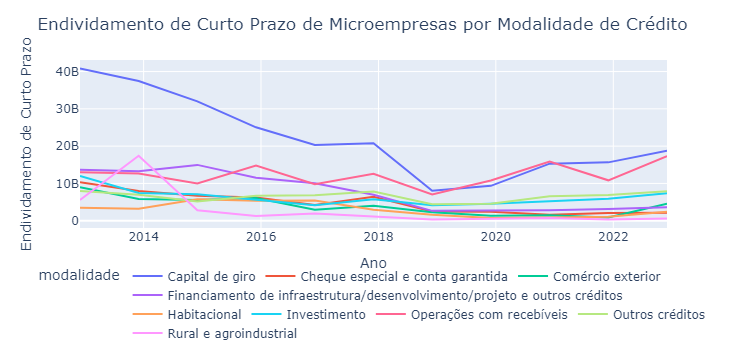

In [28]:
fig = px.line(df_total_micro, 
             x='data_base',
             y='curto_prazo_deflacionado', 
             color='modalidade')

fig.update_layout(title_text='Endividamento de Curto Prazo de Microempresas por Modalidade de Crédito',
             xaxis_title='Ano',
             yaxis_title='Endividamento de Curto Prazo',
             legend_orientation="h",
             legend=dict(y=-0.2, x=0.5, xanchor='center'))

fig.show()

In [22]:
df_total_pequeno=df_total[df_total['porte']=='Pequeno']

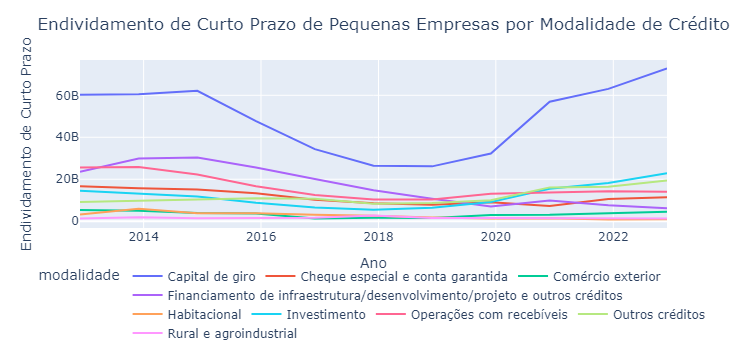

In [27]:
fig = px.line(df_total_pequeno, 
             x='data_base',
             y='curto_prazo_deflacionado', 
             color='modalidade')

fig.update_layout(title_text='Endividamento de Curto Prazo de Pequenas Empresas por Modalidade de Crédito',
             xaxis_title='Ano',
             yaxis_title='Endividamento de Curto Prazo',
             legend_orientation="h",
             legend=dict(y=-0.2, x=0.5, xanchor='center'))

fig.show()